# Naive Bayes

- Spam or no Spam

> The code below can be found in the book as well with minor changes....

**The reason this technique is considered `naive` (or simplistic) is that it makes some simple yet extreme assumptions.**  
- In probability terms, we say the events are mutually exclusive.

**What are the events?**  
- The occurrence of one word in the `email` (or any text) is assumed to have no connection with another word.

Nowadays, this assumption can be outright rejected, but the point is: it's a simple yet powerful technique that utilises one of the key concepts of probability to make wise predictions.

The formula representing the above assumption is:

S - event: "message is spam".
&
contain the words like `bitcoin` & `rolex`..

$$
P(X_1 = x_1, \ldots, X_n = x_n \mid S) = P(X_1 = x_1 \mid S) \times \cdots \times P(X_n = x_n \mid S)
$$

> This model was quite popularly used as a Spam filter.

Using the same Bayes’ theorem logic as in the `bitcoin-only` spam filter, we can calculate the probability that a message is spam with this formula:

$$
P(S \mid X = x) = \frac{P(X = x \mid S)}{P(X = x \mid S) + P(X = x \mid \neg S)}
$$

-------
Before we jump on to create our `spam filter`:

Few more things to take care of:
1. As there can be a lot of words in an email, to calculate probability for every vocabulary word and then multiplying them together can result into **underflow** problem.
   > - Floating point numbers too close to 0.
   > - Easier way to deal with them is to use `log`
2. Calculate estimate for $P(Xi|S)$ and $P(Xi|¬S)$
   > - probabilities that a spam message / non-spam message contains the word $w_i$.
   > - To estimate probabilities like $P(X_i|S)$ and $P(X_i|\neg S)$, we use the fraction of spam / nonspam messages containing the word $w_i$.
However, if a word appears only in nonspam messages, we might estimate $P(w_i|S) = 0$, which causes issues for classification.



To fix this, we apply **smoothing** using a pseudocount $k$. 

The smoothed estimate becomes:

$$P(X_i|S) =\frac{k + ws}{2k+ ms}$$

- $ws$ = number of spams containing word $w_i$
- $ms$ = number of spam messages

This prevents zero probabilities and ensures the classifier can handle rare words.

Similarly for $P(X_i | \neg S)$

------------------------------------
## Implementation

### Tokenising messages into simple words

In [1]:
import os
os.chdir("..")

In [2]:
# libraries
import math
import re

from collections import defaultdict
from typing import Set, NamedTuple, List, Tuple, Dict, Iterable

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score

%matplotlib inline

In [4]:
def tokenise(text: str) -> Set[str]:
    text = text.lower()
    all_words = re.findall("[a-z0-9']+", text) # word extraction
    return set(all_words)

In [5]:
assert tokenise("Machine learning is about making a machine learn") == {'a', 'about', 'is', 'learn', 'learning', 'machine', 'making'}

In [6]:
class Message(NamedTuple):
    text: str
    is_spam: bool

- it is a `class` to keep track of `tokens`, `counts` and `labels` from the training data.
- non-spam emails will be categorised as `okay`
--------------------

- The constructor takes one parameter: a pseudocount to use when computing probabilities.
- There are few other params like:
    - Empty set of tokens.
    - Counters to track how often each token appears in spam and okay messages.
    - Counts of how many spam and okay messages it was trained on.

In [7]:
class NaiveBayesClassifier:
    def __init__(self, k: float = 0.5) -> None:
        # smoothing factor
        self.k = k

        self.tokens: Set[str] = set()
        self.token_spam_counts: Dict[str, int] = defaultdict(int)
        self.token_okay_counts: Dict[str, int] = defaultdict(int)
        self.spam_messages = self.okay_messages = 0
        
    def train(self, messages: Iterable[Message]) -> None:
        for message in messages:
            # incrementing message counts
            if message.is_spam:
                self.spam_messages += 1
            else:
                self.okay_messages +=1

            # incrementing word counts
            for token in tokenise(message.text):
                self.tokens.add(token)
                if message.is_spam:
                    self.token_spam_counts[token] += 1
                else:
                    self.token_okay_counts[token] += 1
    def _probabilities(self, token: str) -> Tuple[float, float]:
        """ P(token|spam) and P(token|okay) for
        each token in the vocabulary."""

        spam = self.token_spam_counts[token]
        okay = self.token_okay_counts[token]

        p_token_spam = (spam + self.k) / (self.spam_messages + 2 * self.k)
        p_token_okay = (okay + self.k) / (self.okay_messages + 2 * self.k)

        return p_token_spam, p_token_okay

    def predict(self, text:str) -> float:
        text_tokens = tokenise(text)
        log_prob_if_spam = log_prob_if_okay = 0.0

        # iterating through each word in our vocabulary
        for token in self.tokens:
            prob_if_spam, prob_if_okay = self._probabilities(token)

            # in case `token` exist in the message,
            # add the log prob of its existence.

            if token in text_tokens:
                log_prob_if_spam += math.log(prob_if_spam)
                log_prob_if_okay += math.log(prob_if_okay)

            # OR add the log probability of not finding it.
            # = log(1-probability of finding it)

            else:
                log_prob_if_spam += math.log(1.0 - prob_if_spam)
                log_prob_if_okay += math.log(1.0 - prob_if_okay)
        
        prob_if_spam = math.exp(log_prob_if_spam)
        prob_if_okay = math.exp(log_prob_if_okay)

        return prob_if_spam / (prob_if_spam + prob_if_okay)

## Testing the code
> Some unit tests

In [8]:
messages = [Message('spam rules', is_spam = True), 
            Message('okay rules', is_spam = False),
            Message('hello okay', is_spam = False)]

In [9]:
model = NaiveBayesClassifier(k=0.5)
model.train(messages)

#### checking whether the count is right?

In [10]:
assert model.tokens == {"spam", "okay", "rules", "hello"}
assert model.spam_messages == 1
assert model.okay_messages == 2

In [11]:
assert model.token_spam_counts == {"spam": 1, "rules": 1}
assert model.token_okay_counts == {"okay": 2, "rules": 1, "hello": 1}

#### making a prediction

In [12]:
text = "hello spam"

In [13]:
probs_if_spam = [
    (1+0.5) / (1+2 * 0.5),        # "spam" (present)
    1 - (0 + 0.5) / (1 + 2 * 0.5), # "okay" (not present)
    1 - (1 + 0.5) / (1 + 2 * 0.5), # "rules" (not present)
    (0 + 0.5) / (1+2 * 0.5)        # "hello" (present)
    ]

In [14]:
probs_if_okay = [
    (0+0.5) / (2 + 2 * 0.5),        # "spam" (present)
    1 - (2 + 0.5) / (2 + 2 * 0.5), # "okay" (not present)
    1 - (1 + 0.5) / (2 + 2 * 0.5), # "rules" (not present)
    (1 + 0.5) / (2 + 2 * 0.5)        # "hello" (present)
    ]

In [15]:
p_if_spam = math.exp(sum(math.log(p) for p in probs_if_spam))
p_if_okay = math.exp(sum(math.log(p) for p in probs_if_okay))

In [16]:
p_if_spam, p_if_okay

(0.03515625, 0.006944444444444444)

In [17]:
assert model.predict(text) == p_if_spam / (p_if_spam+p_if_okay)

## Using model
### on real data

> SpamAssassin public corpus(files prefixed with 20021010)

In [18]:
# script to download and unpack
## here, the okay mails will be called 'ham'

from io import BytesIO
import requests
import tarfile

BASE_URL = "https://spamassassin.apache.org/old/publiccorpus"
FILES = ["20021010_easy_ham.tar.bz2", "20021010_hard_ham.tar.bz2", "20021010_spam.tar.bz2"]
OUTPUT_DIR = './data/spam_data'

In [19]:
for filename in FILES:
    # Use requests to get the file contents at each URL.
    content = requests.get(f"{BASE_URL}/{filename}").content

    # wrapping the in-memory bytes so we can use them as a "file."
    fin = BytesIO(content)

    # and extract all the files to the specified output dir.
    with tarfile.open(fileobj=fin, mode='r:bz2') as tf:
        tf.extractall(OUTPUT_DIR)

> The code in the book has focused on only the subject lines, so keeping it that way.

In [20]:
import glob, re

path = "./data/spam_data/*/*"

data: List[Message] = []

for filename in glob.glob(path):
    is_spam = "ham" not in filename

    with open(filename, errors = "ignore") as email_file:
        for line in email_file:
            if line.startswith("Subject:"):
                subject = line.lstrip("Subject: ")
                data.append(Message(subject, is_spam))
                break

### splitting data into training and test set
> Then, building classifier

In [21]:
import random
from support.machine_learning import split_data

random.seed(123)

train_messages, test_messages = split_data(data, 0.75)

model = NaiveBayesClassifier()
model.train(train_messages)

In [22]:
from collections import Counter

predictions = [(message, model.predict(message.text)) 
               for message in test_messages]

In [23]:
confusion_mat = Counter((message.is_spam, spam_probability > 0.5) 
                           for message, spam_probability in predictions)

In [24]:
confusion_mat

Counter({(False, False): 659,
         (True, True): 93,
         (True, False): 45,
         (False, True): 28})

> This looks fine, but it can certainly be made easy to read.

In [25]:
y_true = []
y_pred = []

for (actual, predicted), count in confusion_mat.items():
    y_true.extend([actual] * count)
    y_pred.extend([predicted] * count)

In [26]:
cm = confusion_matrix(y_true, y_pred)

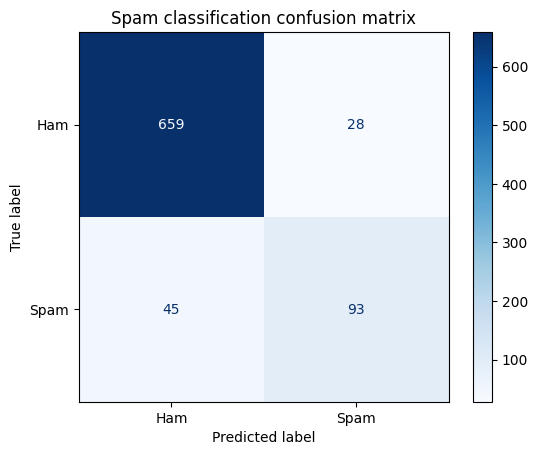

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Spam classification confusion matrix')
plt.show()

In [32]:
recall_score(y_true, y_pred), precision_score(y_true, y_pred), f1_score(y_true, y_pred)

(0.6739130434782609, 0.768595041322314, 0.7181467181467182)

### which words are more towards `spam` and which are more `okay` to be in emails?
> book also address this and I also share the same that it is never advisable to call private methods.

In [35]:
def p_spam_given_token(token: str, model: NaiveBayesClassifier) -> float:
    prob_if_spam, prob_if_okay = model._probabilities(token)

    return prob_if_spam/(prob_if_spam + prob_if_okay)

In [36]:
words = sorted(model.tokens, key=lambda t: p_spam_given_token(t, model))

In [37]:
# spam
words[-10:]

['investment',
 'zzzz',
 'sale',
 'mortgage',
 '500',
 'account',
 'systemworks',
 'money',
 'rates',
 'adv']

In [38]:
# okay words
words[:10]

['spambayes',
 'users',
 'razor',
 'zzzzteana',
 'sadev',
 'apt',
 'perl',
 'ouch',
 'spamassassin',
 'alsa']

# Script Complete